# Template for ML evaluation

There are a few features of the evaluation module, which are explained below. 

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-03-17 17:46:32.972947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 17:46:32.987018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 17:46:32.991174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG','P2L'],  # What data sets to train on
                    'filter_scales':['50','100','200','400'], # What filter scales to train on
                    'window_size':1,  # What stencil we want to train on 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, inputs, outputs, 
                                          'dvdx_widened_rotated_nondim',  # including those used as coefficients (if you want to train y = coeff_var * ANN (x)
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'uphp_rotated_nondim',  # Note these non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], # And will require user to change SimulationData class if normalization needs changing
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  # Inputs to ANN
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim', # Outputs from ANN
                                          'vphp_rotated_nondim'],

                    'use_coeff_channels': False,
                    'coeff_channels'  : [],  # If any coefficients are used

                    'extra_channels'   : [  'uphp_rotated', # These are used during evaluation to go back to dimensional units. 
                                            'vphp_rotated', 
                                            'mag_nabla_h_widened',
                                            'mag_nabla_u_widened',
                                            'filter_scale'],

                    
                    'single_layer_mask': True, # A mask that says whether regions where only one dynamic layer is present should be masked out during training.

                    # The parameters below set how large the datasets need to be etc
                    'all_time_range': slice(0, 768),
                    'train_time_range': slice(0, 128*3),
                    'test_time_range' : slice(128*3, 128*4),
                    'eval_time_range' : slice(128*4, 128*5),
                    'num_train_batches': 3*8, # Each batch will have 16 snapshots
                    'num_test_batches' : 8, # Each batch will have 16 snapshots

                    #'num_inputs': 9*6, # Based on number of inputs and the stencil sizes
                    'num_inputs': 1*6, # Based on number of inputs and the stencil sizes
                    'network_shape': [48, 48, 2], #Shape of network

                    # Set location where the ckpt will be saved
                    'ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/template_trained/shape_48_48_2/'
                    
            }

In [3]:
DT = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                             filter_scales=common_config['filter_scales'], 
                             window_size = common_config['window_size'], 
                             time_sel = common_config['all_time_range'],
                             single_layer_mask_flag=common_config['single_layer_mask']
                             )

In [4]:
DT.simulation_data

DataTree('None', parent=None)
├── DataTree('DG')
│   ├── DataTree('50')
│   │       Dimensions:                      (Time: 768, xh: 200, yh: 218, zl: 2, Xn: 1,
│   │                                         Yn: 1, zi: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 6kB 0001-01-11 00:00:00 ... 00...
│   │         * xh                           (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
│   │         * yh                           (yh) float64 2kB 30.14 30.23 ... 49.77 49.86
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/67)
│   │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           ...                           ...
│   │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           vphp_rotated_nondim          (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           uphp_nondim                  (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           vphp_nondim                  (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           Rd_nondim                    (Time, yh, xh) float64 268MB dask.array<chunksize=(36, 218, 200), meta=np.ndarray>
│   │           single_layer_mask            (Time, yh, xh) float64 268MB dask.array<chunksize=(36, 218, 200), meta=np.ndarray>
│   │       Attributes:
│   │           simulation_name:  DG
│   │           filter_scale:     50
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
│   │           description:      Dataset for DG experiment at 50 km resolution
│   ├── DataTree('100')
│   │       Dimensions:                      (Time: 768, xh: 100, yh: 108, zl: 2, Xn: 1,
│   │                                         Yn: 1, zi: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 6kB 0001-01-11 00:00:00 ... 00...
│   │         * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
│   │         * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/67)
│   │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdy_widened  

### Setting up the evaluation module and the basics

In [5]:
eval_sys = evaluation.EvalSystem(simulation_data=DT,
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= common_config['eval_time_range'], 
                                             num_inputs= common_config['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir=common_config['ckpt_save_dir'],
                                             use_coeff_channels=common_config['use_coeff_channels'])

In [6]:
eval_sys.read_ann_regression_model()
eval_sys.read_eval_data()
eval_sys.predict()
eval_sys.dimensionalize()

In [7]:
eval_sys.eval_datatree.ml_dataset

DataTree('None', parent=None)
├── DataTree('DG')
│   ├── DataTree('50')
│   │       Dimensions:                      (Time: 128, zl: 2, yh: 218, xh: 200, Xn: 1,
│   │                                         Yn: 1)
│   │       Coordinates:
│   │         * Time                         (Time) object 1kB 0015-01-18 00:00:00 ... 00...
│   │         * xh                           (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
│   │         * yh                           (yh) float64 2kB 30.14 30.23 ... 49.77 49.86
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/18)
│   │           dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           ...                           ...
│   │           filter_scale                 (yh, xh, Time) float64 45MB dask.array<chunksize=(218, 200, 28), meta=np.ndarray>
│   │           h_mask                       (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           uphp_rotated_nondim_pred     (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           vphp_rotated_nondim_pred     (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           uphp_rotated_pred            (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           vphp_rotated_pred            (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │       Attributes:
│   │           simulation_name:  DG
│   │           filter_scale:     50
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
│   │           description:      Dataset for DG experiment at 50 km resolution
│   ├── DataTree('100')
│   │       Dimensions:                      (Time: 128, zl: 2, yh: 108, xh: 100, Xn: 1,
│   │                                         Yn: 1)
│   │       Coordinates:
│   │         * Time                         (Time) object 1kB 0015-01-18 00:00:00 ... 00...
│   │         * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
│   │         * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/18)
│   │           dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB das

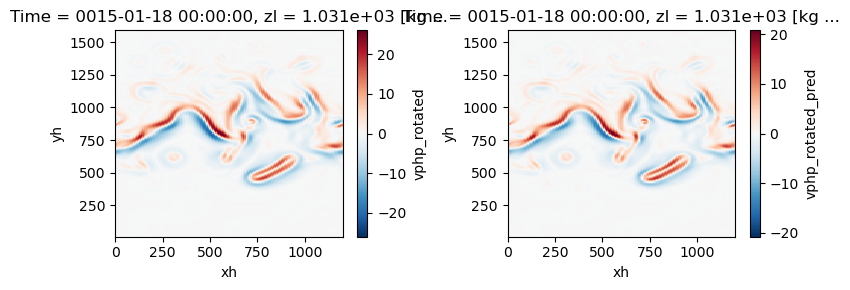

In [8]:
plt.figure(figsize=(8,3))

plt.subplot(121)
eval_sys.eval_datatree.ml_dataset['P2L']['50'].vphp_rotated.isel(Time=0, zl=0).plot()

plt.subplot(122)
eval_sys.eval_datatree.ml_dataset['P2L']['50'].vphp_rotated_pred.isel(Time=0, zl=0).plot()

plt.tight_layout()

### Calculating metrics

### Working with online data
This is unfiltered data, which just directly comes from a lower resolution simulation. 

In [4]:
DT_online = datasets.SimulationData(simulation_names=['P2L'], 
                             filter_scales=['100'], 
                             window_size = 3, 
                             single_layer_mask_flag=common_config['single_layer_mask'],
                             data_form = 'regular' ,
                             online_window_value = 3,
                             add_middle_interface = False,
                             add_layer_decomposition = False,
                             variables_to_widen = ['dudx','dvdx','dudy','dvdy','dhdx','dhdy']      
                             )

eval_sys_online_3 = evaluation.EvalSystem(simulation_data=DT_online,
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= slice(0, -1), 
                                             num_inputs= common_config['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir='/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/template_trained/shape_48_48_2_window3/',
                                             use_coeff_channels=common_config['use_coeff_channels'])

eval_sys_online_3.read_ann_regression_model()
eval_sys_online_3.read_eval_data()
eval_sys_online_3.predict()
eval_sys_online_3.dimensionalize()

~/mesoscale_buoyancy_param_ML/online_analysis_Greene/Phillips2Layer/example_data_window3.netcdf


In [5]:
DT_online = datasets.SimulationData(simulation_names=['P2L'], 
                             filter_scales=['100'], 
                             window_size = 1, 
                             single_layer_mask_flag=common_config['single_layer_mask'],
                             data_form = 'regular' ,
                             online_window_value= 1, 
                             add_middle_interface = False,
                             add_layer_decomposition = False,
                             variables_to_widen = ['dudx','dvdx','dudy','dvdy','dhdx','dhdy']      
                             )

eval_sys_online_1 = evaluation.EvalSystem(simulation_data=DT_online,
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= slice(0, -1), 
                                             num_inputs= common_config['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir='/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/template_trained/shape_48_48_2/',
                                             use_coeff_channels=common_config['use_coeff_channels'])

eval_sys_online_1.read_ann_regression_model()
eval_sys_online_1.read_eval_data()
eval_sys_online_1.predict()
eval_sys_online_1.dimensionalize()

~/mesoscale_buoyancy_param_ML/online_analysis_Greene/Phillips2Layer/example_data.netcdf


In [12]:
ds = eval_sys_online_3.simulation_data.simulation_data['P2L']['100'].to_dataset()

In [13]:
ds

<xarray.Dataset> Size: 12GB
Dimensions:                      (yh: 80, zl: 2, Time: 15, xh: 60, Xn: 3,
                                  Yn: 3, xq: 61, yq: 81, zi: 3)
Coordinates:
  * yh                           (yh) float64 640B 10.0 30.0 ... 1.59e+03
  * zl                           (zl) float64 16B 1.031e+03 1.033e+03
  * Time                         (Time) object 120B 0001-01-11 00:00:00 ... 0...
  * xh                           (xh) float64 480B 10.0 30.0 ... 1.19e+03
  * xq                           (xq) float64 488B 0.0 20.0 ... 1.18e+03 1.2e+03
  * yq                           (yq) float64 648B 0.0 20.0 ... 1.58e+03 1.6e+03
  * zi                           (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
Dimensions without coordinates: Xn, Yn
Data variables: (12/61)
    dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    ...                           ...
    uphp_rotated_nondim          (Time, zl, yh, xh) float64 1MB -0.0004703 .....
    vphp_rotated_nondim          (Time, zl, yh, xh) float64 1MB 7.537e-05 ......
    uphp_nondim                  (Time, zl, yh, xh) float64 1MB 0.0002191 ......
    vphp_nondim                  (Time, zl, yh, xh) float64 1MB 0.0004229 ......
    Rd_nondim                    (Time, yh, xh, zl) float64 1MB 0.4727 ... 0....
    single_layer_mask            (Time, yh, xh) float64 576kB 1.0 1.0 ... 1.0
Attributes:
    filename:         prog.nc
    title:            Phillips experiment
    grid_type:        regular
    grid_tile:        N/A
    simulation_name:  P2L
    filter_scale:     100
    source:           ~/mesoscale_buoyancy_param_ML/online_analysis_Greene/Ph...
    description:      Dataset for P2L experiment at 100 km resolution

In [28]:
ds.dudx_widened_rotated_nondim.isel(Time=5, zl=0).isel(xh=10, yh=10)

<xarray.DataArray 'dudx_widened_rotated_nondim' (Xn: 3, Yn: 3)> Size: 72B
array([[0.00584846, 0.00683339, 0.00744461],
       [0.00521402, 0.00649071, 0.00751157],
       [0.00301642, 0.00431523, 0.0057667 ]])
Coordinates:
    yh       float64 8B 210.0
    zl       float64 8B 1.031e+03
    Time     object 8B 0001-03-02 00:00:00
    xh       float64 8B 210.0
Dimensions without coordinates: Xn, Yn

In [18]:
ml_ds = eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].to_dataset()

In [29]:
ml_ds.dudx_widened_rotated_nondim.isel(Time=5, zl=0).isel(xh=10, yh=10)

<xarray.DataArray 'dudx_widened_rotated_nondim' (Xn: 3, Yn: 3)> Size: 72B
array([[0.00584846, 0.00683339, 0.00744461],
       [0.00521402, 0.00649071, 0.00751157],
       [0.00301642, 0.00431523, 0.0057667 ]])
Coordinates:
    yh       float64 8B 210.0
    zl       float64 8B 1.031e+03
    Time     object 8B 0001-03-02 00:00:00
    xh       float64 8B 210.0
Dimensions without coordinates: Xn, Yn

In [31]:
input_ds = ml_ds[eval_sys_online_3.input_channels]
input_ds

<xarray.Dataset> Size: 58MB
Dimensions:                      (Time: 14, zl: 2, yh: 80, xh: 60, Xn: 3, Yn: 3)
Coordinates:
  * yh                           (yh) float64 640B 10.0 30.0 ... 1.59e+03
  * zl                           (zl) float64 16B 1.031e+03 1.033e+03
  * Time                         (Time) object 112B 0001-01-11 00:00:00 ... 0...
  * xh                           (xh) float64 480B 10.0 30.0 ... 1.19e+03
Dimensions without coordinates: Xn, Yn
Data variables:
    dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
    dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
Attributes:
    filename:         prog.nc
    title:            Phillips experiment
    grid_type:        regular
    grid_tile:        N/A
    simulation_name:  P2L
    filter_scale:     100
    source:           ~/mesoscale_buoyancy_param_ML/online_analysis_Greene/Ph...
    description:      Dataset for P2L experiment at 100 km resolution

In [42]:
input_ds.dudx_widened_rotated_nondim.isel(Time=5, zl=0).isel(xh=10, yh=10, Xn=1, Yn=1)

<xarray.DataArray 'dudx_widened_rotated_nondim' ()> Size: 8B
array(0.00649071)
Coordinates:
    yh       float64 8B 210.0
    zl       float64 8B 1.031e+03
    Time     object 8B 0001-03-02 00:00:00
    xh       float64 8B 210.0

In [43]:
input_ds.dudx_widened_rotated_nondim.isel(Time=5, zl=0).isel(xh=9, yh=10, Xn=1, Yn=1)

<xarray.DataArray 'dudx_widened_rotated_nondim' ()> Size: 8B
array(0.00680198)
Coordinates:
    yh       float64 8B 210.0
    zl       float64 8B 1.031e+03
    Time     object 8B 0001-03-02 00:00:00
    xh       float64 8B 190.0

In [44]:
input_ds.dudx_widened_rotated_nondim.isel(Time=5, zl=0).isel(xh=10, yh=11, Xn=1, Yn=1)

<xarray.DataArray 'dudx_widened_rotated_nondim' ()> Size: 8B
array(0.00486033)
Coordinates:
    yh       float64 8B 230.0
    zl       float64 8B 1.031e+03
    Time     object 8B 0001-03-02 00:00:00
    xh       float64 8B 190.0

In [40]:
temp = input_ds.dudx_widened_rotated_nondim.isel(Time=5, zl=0).isel(xh=10, yh=10)
temp

<xarray.DataArray 'dudx_widened_rotated_nondim' (Xn: 3, Yn: 3)> Size: 72B
array([[0.00584846, 0.00683339, 0.00744461],
       [0.00521402, 0.00649071, 0.00751157],
       [0.00301642, 0.00431523, 0.0057667 ]])
Coordinates:
    yh       float64 8B 210.0
    zl       float64 8B 1.031e+03
    Time     object 8B 0001-03-02 00:00:00
    xh       float64 8B 210.0
Dimensions without coordinates: Xn, Yn

In [41]:
temp[0,0], temp[0,1], temp[0,2]

(<xarray.DataArray 'dudx_widened_rotated_nondim' ()> Size: 8B
 array(0.00584846)
 Coordinates:
     yh       float64 8B 210.0
     zl       float64 8B 1.031e+03
     Time     object 8B 0001-03-02 00:00:00
     xh       float64 8B 210.0,
 <xarray.DataArray 'dudx_widened_rotated_nondim' ()> Size: 8B
 array(0.00683339)
 Coordinates:
     yh       float64 8B 210.0
     zl       float64 8B 1.031e+03
     Time     object 8B 0001-03-02 00:00:00
     xh       float64 8B 210.0,
 <xarray.DataArray 'dudx_widened_rotated_nondim' ()> Size: 8B
 array(0.00744461)
 Coordinates:
     yh       float64 8B 210.0
     zl       float64 8B 1.031e+03
     Time     object 8B 0001-03-02 00:00:00
     xh       float64 8B 210.0)

In [33]:
X_xr = input_ds.to_stacked_array("input_features", sample_dims=['Time', 'zl', 'yh', 'xh'])

In [35]:
X_xr.isel(Time=5, zl=0).isel(xh=10, yh=10)

<xarray.DataArray 'dudx_widened_rotated_nondim' (input_features: 54)> Size: 432B
array([ 5.84845935e-03,  6.83339131e-03,  7.44461228e-03,  5.21402207e-03,
        6.49070725e-03,  7.51157404e-03,  3.01642257e-03,  4.31522777e-03,
        5.76669718e-03, -2.62708708e-01, -3.23695823e-01, -3.99613545e-01,
       -2.62057388e-01, -3.23475933e-01, -3.99952815e-01, -2.61360478e-01,
       -3.22920692e-01, -3.99749074e-01,  8.10128646e-04,  7.39198196e-04,
        3.97605396e-04, -4.24739139e-03, -2.86794335e-03, -1.79009871e-03,
       -9.84458596e-03, -7.00751618e-03, -4.21025021e-03, -6.67688519e-03,
       -7.47803087e-03, -7.82726870e-03, -5.74185141e-03, -6.76036893e-03,
       -7.43404228e-03, -2.28773502e-03, -3.53382036e-03, -4.87038082e-03,
        2.67618794e-01,  3.25605348e-01,  3.96862562e-01,  2.66813600e-01,
        3.24629079e-01,  3.95812014e-01,  2.66202206e-01,  3.23809876e-01,
        3.94828739e-01, -1.21252990e-03,  2.76282557e-05,  1.44790276e-03,
       -1.22278512e-03,  0.00000000e+00,  1.47782411e-03,  4.02204096e-04,
        1.24404328e-03,  2.37058547e-03])
Coordinates:
    yh              float64 8B 210.0
    zl              float64 8B 1.031e+03
    Time            object 8B 0001-03-02 00:00:00
    xh              float64 8B 210.0
  * input_features  (input_features) object 432B MultiIndex
  * variable        (input_features) <U27 6kB 'dudx_widened_rotated_nondim' ....
  * Xn              (input_features) int64 432B 0 0 0 1 1 1 2 ... 0 1 1 1 2 2 2
  * Yn              (input_features) int64 432B 0 1 2 0 1 2 0 ... 2 0 1 2 0 1 2

In [38]:
X_xr.isel(Time=5, zl=0).isel(xh=10, yh=10)[0:6]

<xarray.DataArray 'dudx_widened_rotated_nondim' (input_features: 6)> Size: 48B
array([0.00584846, 0.00683339, 0.00744461, 0.00521402, 0.00649071,
       0.00751157])
Coordinates:
    yh              float64 8B 210.0
    zl              float64 8B 1.031e+03
    Time            object 8B 0001-03-02 00:00:00
    xh              float64 8B 210.0
  * input_features  (input_features) object 48B MultiIndex
  * variable        (input_features) <U27 648B 'dudx_widened_rotated_nondim' ...
  * Xn              (input_features) int64 48B 0 0 0 1 1 1
  * Yn              (input_features) int64 48B 0 1 2 0 1 2

In [22]:
eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100']

DataTree('100', parent="P2L")
    Dimensions:                      (Time: 14, zl: 2, yh: 80, xh: 60, Xn: 3, Yn: 3)
    Coordinates:
      * yh                           (yh) float64 640B 10.0 30.0 ... 1.59e+03
      * zl                           (zl) float64 16B 1.031e+03 1.033e+03
      * Time                         (Time) object 112B 0001-01-11 00:00:00 ... 0...
      * xh                           (xh) float64 480B 10.0 30.0 ... 1.19e+03
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/18)
        dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
        dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
        dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
        dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
        dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
        dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 10MB nan ...
        ...                           ...
        filter_scale                 (Time, zl, yh, xh) float64 1MB 1e+05 ... 1e+05
        h_mask                       (Time, zl, yh, xh) float64 1MB 1.0 1.0 ... 1.0
        uphp_rotated_nondim_pred     (Time, zl, yh, xh) float64 1MB nan nan ... nan
        vphp_rotated_nondim_pred     (Time, zl, yh, xh) float64 1MB nan nan ... nan
        uphp_rotated_pred            (Time, zl, yh, xh) float64 1MB nan nan ... nan
        vphp_rotated_pred            (Time, zl, yh, xh) float64 1MB nan nan ... nan
    Attributes:
        filename:         prog.nc
        title:            Phillips experiment
        grid_type:        regular
        grid_tile:        N/A
        simulation_name:  P2L
        filter_scale:     100
        source:           ~/mesoscale_buoyancy_param_ML/online_analysis_Greene/Ph...
        description:      Dataset for P2L experiment at 100 km resolution

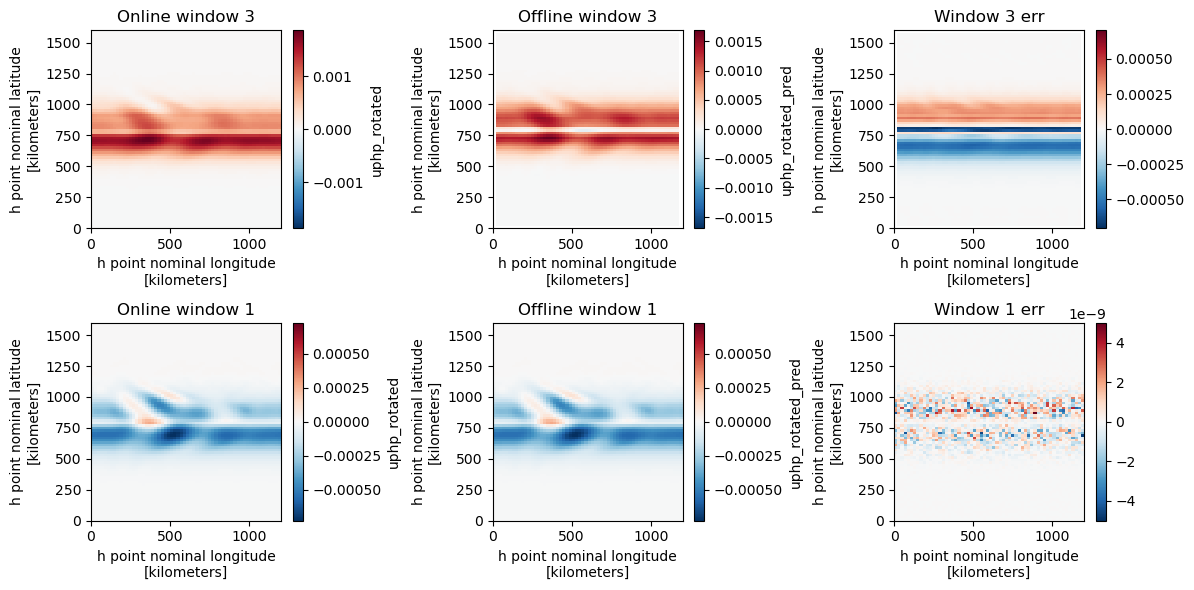

In [21]:
plt.figure(figsize=(12, 6))
idT = 2

var = 'uphp'

plt.subplot(231)
eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated'].isel(Time=idT, zl=0).plot()
plt.title('Online window 3')

plt.subplot(232)
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25. ).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Offline window 3')


plt.subplot(233)
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25. - eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated']).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Window 3 err')


plt.subplot(234)
eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated'].isel(Time=idT, zl=0).plot()
plt.title('Online window 1')

plt.subplot(235)
(eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25.).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Offline window 1')

plt.subplot(236)
(eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated_pred']/25. - eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'][var+'_rotated']).isel(Time=idT, zl=0).plot() # This factor of 
plt.title('Window 1 err')

plt.tight_layout()

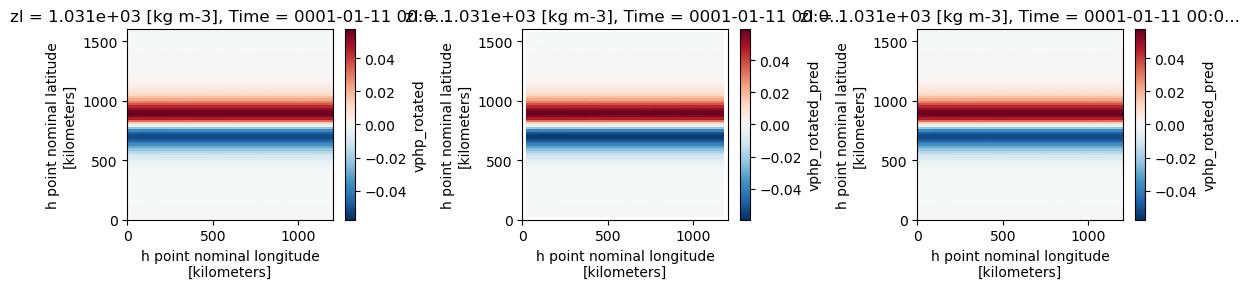

In [20]:
plt.figure(figsize=(12,3))

plt.subplot(131)
eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].vphp_rotated.isel(Time=0, zl=0).plot()

plt.subplot(132)
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].vphp_rotated_pred/25).isel(Time=0, zl=0).plot() # This factor of 

plt.subplot(133)
(eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'].vphp_rotated_pred/25).isel(Time=0, zl=0).plot() # This factor of 

plt.tight_layout()

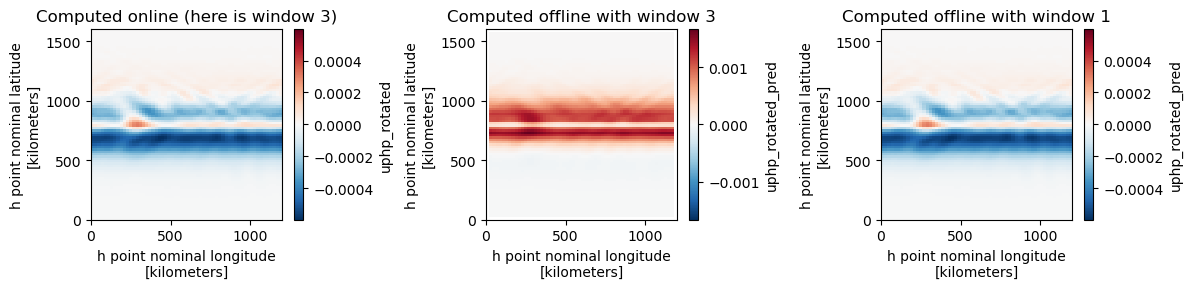

In [21]:
plt.figure(figsize=(12,3))

plt.subplot(131)
eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].uphp_rotated.isel(Time=0, zl=0).plot()
plt.title('Computed online (here is window 3)')

plt.subplot(132)
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_pred/25).isel(Time=0, zl=0).plot() # This factor of 
plt.title('Computed offline with window 3')

plt.subplot(133)
(eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_pred/25).isel(Time=0, zl=0).plot() # This factor of 
plt.title('Computed offline with window 1')

plt.tight_layout()

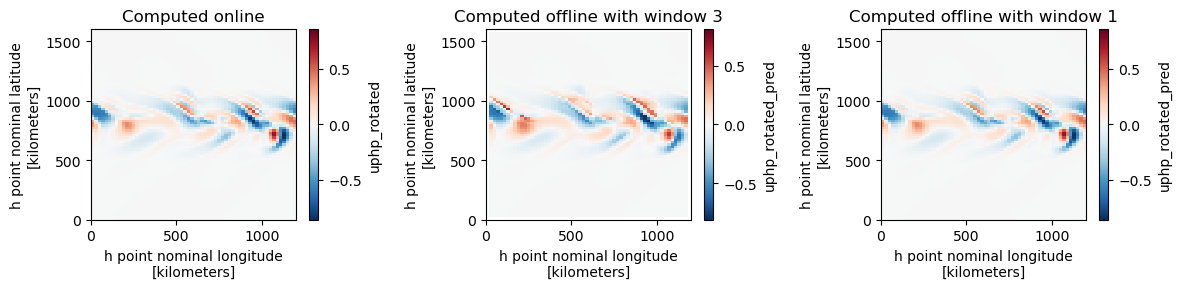

In [25]:
plt.figure(figsize=(12,3))

plt.subplot(131)
eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].uphp_rotated.isel(Time=-1, zl=0).plot()
plt.title('Computed online')

plt.subplot(132)
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_pred/25).isel(Time=-1, zl=0).plot() # This factor of 
plt.title('Computed offline with window 3')

plt.subplot(133)
(eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_pred/25).isel(Time=-1, zl=0).plot() # This factor of 
plt.title('Computed offline with window 1')

plt.tight_layout()

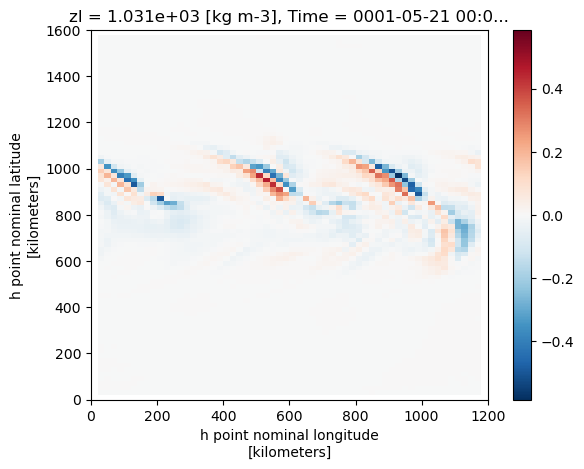

In [26]:
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].uphp_rotated - eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_pred/25).isel(Time=-1, zl=0).plot()

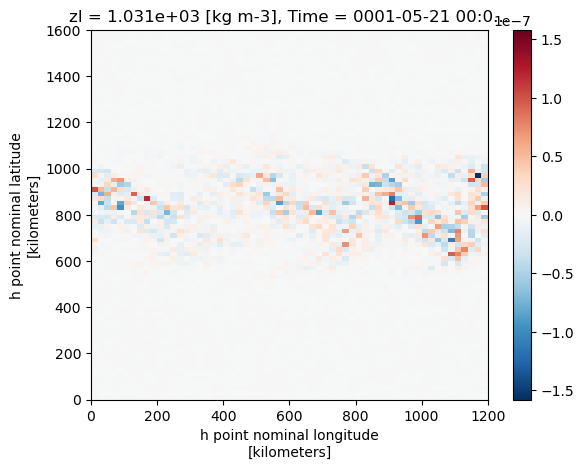

In [27]:
(eval_sys_online_3.eval_datatree.ml_dataset['P2L']['100'].uphp_rotated - eval_sys_online_1.eval_datatree.ml_dataset['P2L']['100'].uphp_rotated_pred/25).isel(Time=-1, zl=0).plot()